In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#Import packages
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from itertools import count
from collections import deque

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


In [3]:
#Import Custom Classes

from Source.NN_model_2 import QNetwork
from Source.dqn_agent_2 import Agent, ReplayBuffer, EpsilonGreedyStrategy
from Source.Env_Manager import EnvManager
from Source.Misc import plot



In [4]:
#Hyper-parameters
BUFFER_SIZE = int(1e5)      #replay buffer size
BATCH_SIZE = 60             #minibatch size
GAMMA = 0.999                #discount factor
TAU = 1e-3                  #for soft update of target parameters
LR = 5e-4                   #learning rate
UPDATE_EVERY = 50            #how often to update the network
eps_start = 1
eps_end = 0.01
eps_decay = 0.9983 #125e-6
train_episodes = 2500
test_episodes = 1
seed = 0                    #random seed number
episode_step_limit = 50

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Choose the environment
em = EnvManager(device, 'uav-v3', seed)
available_actions = em.num_actions_available()
random.seed(seed)

#Select the strategy
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)

#Initialize the agent
agent = Agent(strategy, available_actions, seed, device)

#Instantiate MemoryBuffer
memory = ReplayBuffer(available_actions, BUFFER_SIZE, BATCH_SIZE, seed, device)

policy_net = QNetwork(available_actions, seed).to(device)
target_net = QNetwork(available_actions, seed).to(device)
print(policy_net)

#Initialize target_net weights to policy_net weights
target_net.load_state_dict(policy_net.state_dict())
target_net.eval() #Set the target_net in eval mode

#Select the optimizer
optimizer = optim.Adam(params=policy_net.parameters(), lr=LR)

QNetwork(
  (fc1): Linear(in_features=2, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=32, bias=True)
)


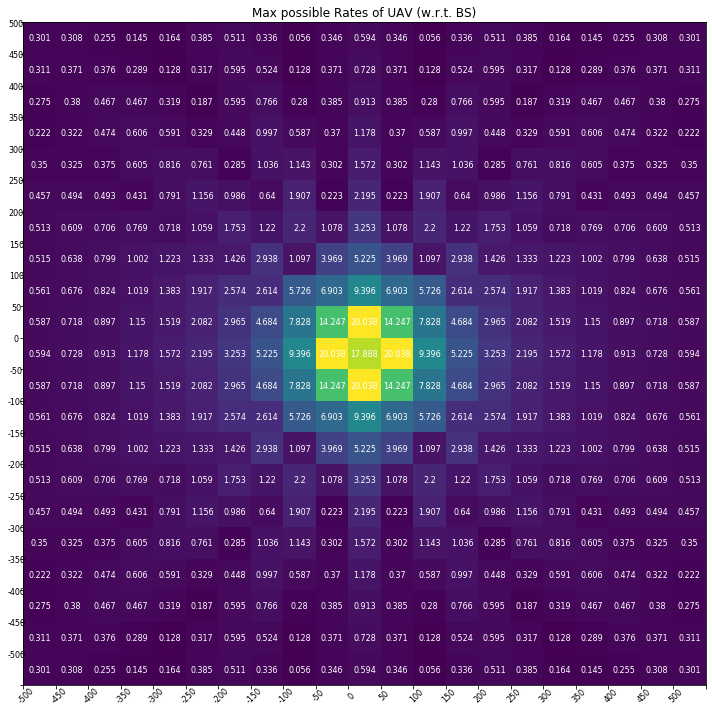

In [6]:
rate_tr = 0.0
t_step = 0
ue_xloc = em.env.ue_xloc  #10 locs
ue_yloc = em.env.ue_yloc[::-1]     #5 locs

rate_arr = np.zeros([(max(ue_yloc)-min(ue_yloc))//50 +1, (max(ue_xloc)-min(ue_xloc))//50 + 1]) #(-500,50) -----> (500,500)
for y_ndx in range(len(ue_yloc)):
    for x_ndx in range(len(ue_xloc)):
        state = np.array([ue_xloc[x_ndx], ue_yloc[y_ndx]])/ em.env.high_obs
        exh_bdir,exh_rate = em.env.get_Exh_Rate(state)
        rate_arr[y_ndx,x_ndx] = np.around(exh_rate, decimals=3)

row_labels = [str(x) for x in ue_yloc]
col_labels = [str(x) for x in ue_xloc]

fig, ax = plt.subplots(1,1, figsize=(10,10))
im = ax.imshow(rate_arr, aspect='auto')

# We want to show all ticks...
ax.set_xticks(np.arange(rate_arr.shape[1]+1)-.5)
ax.set_yticks(np.arange(rate_arr.shape[0]+1)-.5)
# ... and label them with the respective list entries
ax.set_xticklabels(col_labels, fontsize=8)
ax.set_yticklabels(row_labels, fontsize=8)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="center",
         rotation_mode="anchor")
plt.setp(ax.get_yticklabels(), rotation=0, ha="center",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(rate_arr.shape[0]):
    for j in range(rate_arr.shape[1]):
        text = ax.text(j, i, rate_arr[i, j],
                       ha="center", va="center", color="w", fontsize=8)

ax.set_title("Max possible Rates of UAV (w.r.t. BS)")
fig.tight_layout()
plt.show()

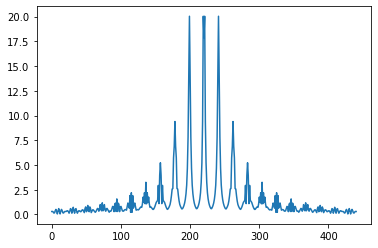

In [7]:
rate_arr = rate_arr.flatten()

plt.plot(rate_arr)
plt.show()

[0.39269908 0.78539816 1.17809725 1.57079633 1.96349541 2.35619449
 2.74889357 3.14159265 3.53429174]
[0.3926990816987242, 0.7853981633974483, 1.1780972450961724, 1.5707963267948966, 1.9634954084936207, 2.356194490192345, 2.748893571891069, 3.141592653589793, -2.7488935718910694]


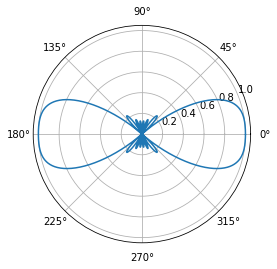

In [8]:
ang=np.arange(np.pi/8, 10*np.pi/8, np.pi/8)
print(ang)
tan_ang=[]
for a in ang:
    tan_ang.append(np.arctan2(np.sin(a), np.cos(a)))
    
print(tan_ang)

from Source.MIMO import plotbeam

theta, gr = plotbeam(np.pi, 8)
ax = plt.subplot(111, projection='polar')
ax.plot(theta, gr)
plt.show()

In [9]:
print(rate_arr[50])
rate_thr = rate_arr[50]

0.28


Testing Environment with untrained Agent

torch.Size([1, 2])
action:  26
action:  31
action:  19
action:  22
action:  13


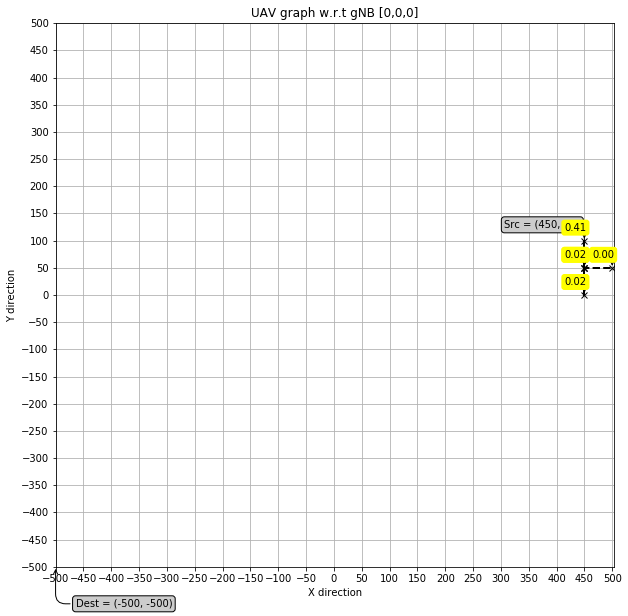

UAV Source: (450, 50), UAV dest: (-500, -500)


In [10]:
state = em.reset(rate_thr)
#state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(device)
print(state.shape)
for j in range(5):
    action = agent.act(state, policy_net)
    print("action: ", action.item())
    #print("Action: {}, Qval: {}".format(action, qval))
    #env.render()
    #print("[NB] action: {}".format(action))
    state, reward, done, _ = em.step(action)
    #state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(device)
    if done:
        break 
        
em.env.render()      
em.close()
print("UAV Source: {0}, UAV dest: {1}".format((em.env.ue_xsrc, em.env.ue_ysrc), (em.env.ue_xdest[0], em.env.ue_ydest[0]) ))

Training the DQN Agent

training loop: 100% |###########################################| Time: 0:35:42


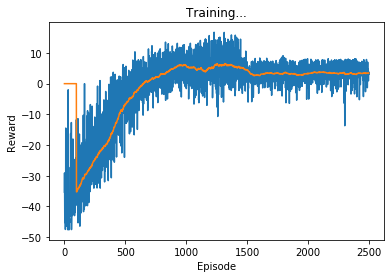

Episode 2500 
 100 episode moving avg: 3.4490585


In [11]:
#Training Loop
episode_durations = []
episode_rewards = []
policy_net.train()

import progressbar as pb
widget = ['training loop: ', pb.Percentage(), ' ', 
          pb.Bar(), ' ', pb.ETA() ]
timer = pb.ProgressBar(widgets=widget, maxval=train_episodes).start()


for episode in range(train_episodes):
    state = em.reset(rate_thr)
    
    #state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(device)
    ep_loss = 0.0
    ep_rwd = 0.0
    timestep = 0
    agent.current_step +=1
    for timestep in count():
        action = agent.act(state, policy_net)
        next_state, reward, done, _ = em.step(action)
        ep_rwd += reward.item()
        memory.add(state, action, reward, next_state, done)
        
        state = next_state
        #state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(device)
        
        if memory.can_provide_sample():
            experiences = memory.sample()
            states, actions, rewards, next_states, dones = experiences
            
            #print(states.shape, states.dtype)
            #print(actions.unsqueeze(-1).shape)
            current_q_values = policy_net(states).gather(1,index=actions.unsqueeze(-1))
            next_q_values = target_net(next_states).detach().max(1)[0]
            target_q_values = (next_q_values*GAMMA) + rewards
            
            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
            #print("loss: ", loss.item())
            ep_loss += loss.item()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        if (timestep==episode_step_limit) or done:
            episode_durations.append(timestep)
            episode_rewards.append(ep_rwd)
            print('\rEpisode {}\t timestep: {},\tScore: {:.2f}, eps: {}'.format(episode+1, timestep, ep_rwd, agent.strategy.get_exploration_rate(agent.current_step)))
            plot(episode_rewards, 100)
            break
            
        
    if episode % UPDATE_EVERY == 0:
        target_net.load_state_dict(policy_net.state_dict())
    
    if (np.mean(episode_rewards[-100:]) >= 20000):
        print("Goal is reached in {} episodes!\n".format(episode))
        break
        
    torch.save(policy_net.state_dict(), 'checkpoint.pth')
    
    # update progress widget bar
    timer.update(episode+1)
    
timer.finish()
plot(episode_rewards, 100)
#em.close()

Testing the DQN agent

Current State:  [-100.  250.]
Next State:  [-100.  200.]
time step:  1
action parameters: ue_vx: 0, ue_vy: -50
exh dir: 1.9634954084936207, learnt bdir: 1.9634954084936207
Rwd: tensor([0.2931], device='cuda:0'), Learnt Rate: 2.199917583487442, Exh_Rate: 2.199917583487443, Los_Rate: 2.678515762126975


Current State:  [-100.  200.]
Next State:  [-100.  150.]
time step:  2
action parameters: ue_vx: 0, ue_vy: -50
exh dir: 2.356194490192345, learnt bdir: 1.9634954084936207
Rwd: tensor([0.2185], device='cuda:0'), Learnt Rate: 0.6877206566845092, Exh_Rate: 1.097377490888813, Los_Rate: 3.8778606948130268


Current State:  [-100.  150.]
Next State:  [-100.  100.]
time step:  3
action parameters: ue_vx: 0, ue_vy: -50
exh dir: 2.356194490192345, learnt bdir: 2.356194490192345
Rwd: tensor([0.4387], device='cuda:0'), Learnt Rate: 5.7259324409902925, Exh_Rate: 5.7259324409902925, Los_Rate: 5.7259324409902925


Current State:  [-100.  100.]
Next State:  [-150.  100.]
time step:  4
action parameters:

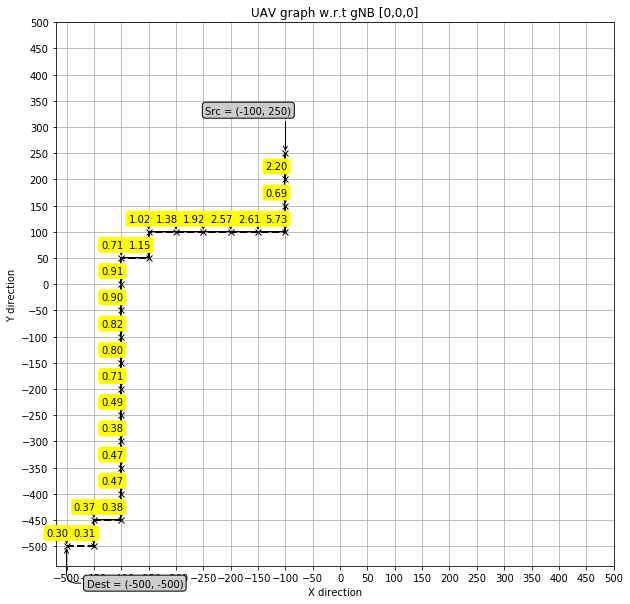

In [52]:
#Load the weights from file
policy_net.load_state_dict(torch.load('checkpoint.pth'))
#rate_thr = rate_arr[50]

rate_acc_los_scores = []
rate_acc_exh_scores = []
learnt_val_fns = []
true_val_fns = []
test_scores = []
policy_net.eval()
for i_episode in range(1):
    
    learnt_rates = 0.0
    los_rates = 0.0
    exh_rates = 0.0
    state_tensor = em.reset(rate_thr)
    learnt_val_fn = 0.0
    true_val_fn = 0.0
    perf_score = 0
    for t_step in count():
        action = policy_net(state_tensor).argmax(dim=1).to(device)#agent.act(state_tensor, policy_net)
        next_state_tensor, reward, done, _ = em.step(action)
        
        
        state = np.rint(state_tensor.squeeze().cpu().data.numpy() * em.env.high_obs)
        next_state = np.rint(next_state_tensor.squeeze().cpu().data.numpy() * em.env.high_obs)
        print("Current State: ", state)
        print("Next State: ", next_state)
        
        curr_loc = (state[0], state[1])
        next_loc = (next_state[0], next_state[1])
        #print("Test Episode: {2}, Current Location: {0}, Next Location: {1}".format(curr_loc, next_loc, i_episode))
        #print("Learnt Action: ", test_net(state))
        
            
        next_state = next_state / em.env.high_obs
        state = state / em.env.high_obs
        
        state_tensor = torch.tensor(np.array([next_state]), dtype=torch.float32).to(device)
        
        
        
        #rate measurements
        learnt_rate = em.env.get_Rate()
        _,los_rate = em.env.get_Los_Rate(next_state)
        exh_bdir,exh_rate = em.env.get_Exh_Rate(next_state)
        
        if (learnt_rate > em.env.rate_threshold):
            perf_score +=1
        learnt_val_fn += ((GAMMA**(t_step)) * (learnt_rate))
        true_val_fn += ((GAMMA**(t_step)) * (exh_rate))
        
        rbd_ndx, ue_mv_ndx = em.env.decode_action(action)
        ue_vx, ue_vy = em.env.choose_vel(ue_mv_ndx)
        print("time step: ", t_step+1)
        print("action parameters: ue_vx: {}, ue_vy: {}".format(ue_vx, ue_vy))
        print("exh dir: {0}, learnt bdir: {1}".format(exh_bdir, em.env.BeamSet[rbd_ndx]))
        print("Rwd: {3}, Learnt Rate: {0}, Exh_Rate: {1}, Los_Rate: {2}\n\n".format(learnt_rate, exh_rate, los_rate, reward))
        
       
        if (t_step== episode_step_limit) or done:
            em.env.render()
            break

Compute the value function

In [53]:
#Load the weights from file
policy_net.load_state_dict(torch.load('checkpoint.pth'))
test_episodes = 20

rate_acc_los_scores = []
rate_acc_exh_scores = []
learn_perf_scores = []
trad_perf_scores=[]
learnt_val_fns = []
true_val_fns = []
test_scores = []
eps_times = []
policy_net.eval()

for i_episode in range(1, test_episodes+1):
    
    learnt_rates = 0.0
    los_rates = 0.0
    exh_rates = 0.0
    state_tensor = em.reset(rate_thr)
    learnt_val_fn = 0.0
    true_val_fn = 0.0
    learn_perf_score = 0
    trad_perf_score = 0
    
    for t_step in count():
        action = policy_net(state_tensor).argmax(dim=1).to(device)#agent.act(state_tensor, policy_net)
        
        next_state_tensor, reward, done, _ = em.step(action)
        
        state = np.rint(state_tensor.squeeze().cpu().data.numpy() * em.env.high_obs)
        next_state = np.rint(next_state_tensor.squeeze().cpu().data.numpy() * em.env.high_obs)
        #print("Current State: ", state)
        #print("Next State: ", next_state)

        curr_loc = (state[0], state[1])
        next_loc = (next_state[0], next_state[1])
        #print("Test Episode: {2}, Current Location: {0}, Next Location: {1}".format(curr_loc, next_loc, i_episode))
        #print("Learnt Action: ", test_net(state))
        
            
        next_state = next_state / em.env.high_obs
        state = state / em.env.high_obs
        
        state_tensor = torch.tensor(np.array([next_state]), dtype=torch.float32).to(device)
        
        #rate measurements
        learnt_rate = em.env.get_Rate()
        _,los_rate = em.env.get_Los_Rate(next_state)
        exh_bdir,exh_rate = em.env.get_Exh_Rate(next_state)
        
        learnt_val_fn += ((GAMMA**(t_step)) * (learnt_rate))
        true_val_fn += ((GAMMA**(t_step)) * (exh_rate))
        
        #rbd_ndx, ue_vx_ndx, ue_vy_ndx = em.env.decode_action(action)
        #print("time step: ", t_step+1)
        #print("action parameters: ue_vx: {0}, ue_vy: {1}".format(em.env.ue_vx[ue_vx_ndx], em.env.ue_vx[ue_vx_ndx]))
        #print("exh dir: {0}, learnt bdir: {1}".format(exh_bdir, em.env.BeamSet[rbd_ndx]))
        #print("Rwd: {3}, Learnt Rate: {0}, Exh_Rate: {1}, Los_Rate: {2}\n\n".format(learnt_rate, exh_rate, los_rate, reward))
        if (learnt_rate >= em.env.rate_threshold):
            learn_perf_score +=1
        if (exh_rate >= em.env.rate_threshold):
            trad_perf_score +=1

        los_rates+=los_rate
        exh_rates+=exh_rate
        learnt_rates+=learnt_rate
        
        if (t_step== episode_step_limit) or done:
            rate_acc_los = learnt_rates/ los_rates
            rate_acc_exh = learnt_rates / exh_rates
            print("\rTest epsiode: {}\t rate_acc_los: {:.2f}\trate_acc_exh: {:.2f}, episode_len: {}, perf_score: {}".format(i_episode, rate_acc_los, rate_acc_exh, t_step, learn_perf_score))
            rate_acc_los_scores.append(rate_acc_los)
            rate_acc_exh_scores.append(rate_acc_exh)
            learn_perf_scores.append(learn_perf_score)
            trad_perf_scores.append(trad_perf_score)
            eps_times.append(t_step)
            
            learnt_val_fns.append(learnt_val_fn)
            true_val_fns.append(true_val_fn)
            break

Test epsiode: 1	 rate_acc_los: 0.84	rate_acc_exh: 0.97, episode_len: 23, perf_score: 23
Test epsiode: 2	 rate_acc_los: 0.83	rate_acc_exh: 0.97, episode_len: 23, perf_score: 24
Test epsiode: 3	 rate_acc_los: 0.59	rate_acc_exh: 0.61, episode_len: 34, perf_score: 35
Test epsiode: 4	 rate_acc_los: 0.87	rate_acc_exh: 0.94, episode_len: 13, perf_score: 14
Test epsiode: 5	 rate_acc_los: 0.54	rate_acc_exh: 0.54, episode_len: 25, perf_score: 26
Test epsiode: 6	 rate_acc_los: 0.92	rate_acc_exh: 0.98, episode_len: 14, perf_score: 15
Test epsiode: 7	 rate_acc_los: 0.47	rate_acc_exh: 0.49, episode_len: 31, perf_score: 31
Test epsiode: 8	 rate_acc_los: 0.82	rate_acc_exh: 0.96, episode_len: 24, perf_score: 25
Test epsiode: 9	 rate_acc_los: 0.59	rate_acc_exh: 0.60, episode_len: 30, perf_score: 31
Test epsiode: 10	 rate_acc_los: 0.64	rate_acc_exh: 0.70, episode_len: 23, perf_score: 24
Test epsiode: 11	 rate_acc_los: 0.88	rate_acc_exh: 0.94, episode_len: 15, perf_score: 16
Test epsiode: 12	 rate_acc_los

Plot Rate Accuracies

Avg rate_los_acc: 0.7095211837193024, Avg rate_exh_acc: 0.8023963480833171


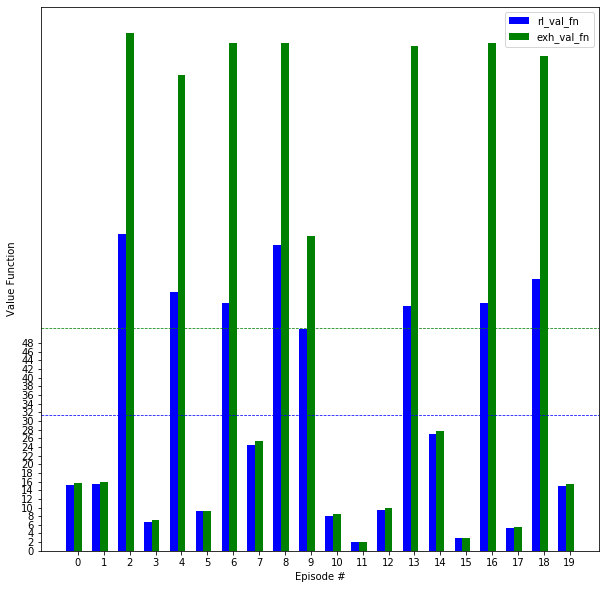

In [54]:
print("Avg rate_los_acc: {}, Avg rate_exh_acc: {}".format(np.mean(rate_acc_los_scores), np.mean(rate_acc_exh_scores)))



# plot the histogram
w=0.3
fig = plt.figure(figsize=(10,10))
x_axis = np.arange(test_episodes)
ax = fig.add_subplot(111)
rects1 = ax.bar(x_axis-w, learnt_val_fns, w, color='b')
rects2= ax.bar(x_axis, true_val_fns, w, color='g')
#plt.legend(loc='upper right')
ax.legend( (rects1[0], rects2[0]), ('rl_val_fn', 'exh_val_fn'), loc='upper right' )
plt.ylabel('Value Function')
plt.xlabel('Episode #')
ax.set_xticks(x_axis)
ax.set_yticks(np.arange(0.0,50,2))

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        #ax.text(rect.get_x()+rect.get_width()/2., 1.03*h, '%.2f'%np.around(h, decimals=2),
        #        ha='center', va='bottom')

ax.axhline(np.mean(learnt_val_fns), color='b', linewidth=0.75, linestyle='--')
ax.axhline(np.mean(true_val_fns), color='g', linewidth=0.75, linestyle='--')
autolabel(rects1)
autolabel(rects2)
plt.show()

Plot Efficiency Scores

Avg Efficiceny_RL: 31.475556066627387, Avg Efficiency_Exh: 6.445746184947426


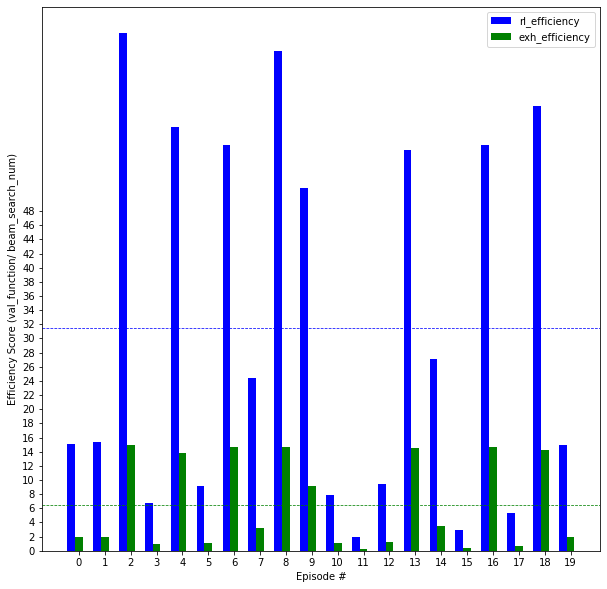

In [55]:
rl_efficiency_scores = [ x for x in learnt_val_fns]
exh_efficiency_scores = [x/em.env.N_rx for x in true_val_fns]

print("Avg Efficiceny_RL: {}, Avg Efficiency_Exh: {}".format(np.mean(rl_efficiency_scores), np.mean(exh_efficiency_scores)))



# plot the histogram
w=0.3
fig = plt.figure(figsize=(10,10))
x_axis = np.arange(test_episodes)
ax = fig.add_subplot(111)
rects1 = ax.bar(x_axis-w, rl_efficiency_scores, w, color='b')
rects2= ax.bar(x_axis, exh_efficiency_scores, w, color='g')
#plt.legend(loc='upper right')
ax.legend( (rects1[0], rects2[0]), ('rl_efficiency', 'exh_efficiency'), loc='upper right' )
plt.ylabel('Efficiency Score (val_function/ beam_search_num)')
plt.xlabel('Episode #')
ax.set_xticks(x_axis)
ax.set_yticks(np.arange(0.0,50,2))

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        #ax.text(rect.get_x()+rect.get_width()/2., 1.03*h, '%.2f'%np.around(h, decimals=2),
        #        ha='center', va='bottom')

ax.axhline(np.mean(rl_efficiency_scores), color='b', linewidth=0.75, linestyle='--')
ax.axhline(np.mean(exh_efficiency_scores), color='g', linewidth=0.75, linestyle='--')
autolabel(rects1)
autolabel(rects2)
plt.show()

Plot Performance Scores for a set Rate Threshold

Avg Perf Score of an Episode, RL: 22.05, Traditional method: 22.05, Perf_Score_Accuracy: 1.0


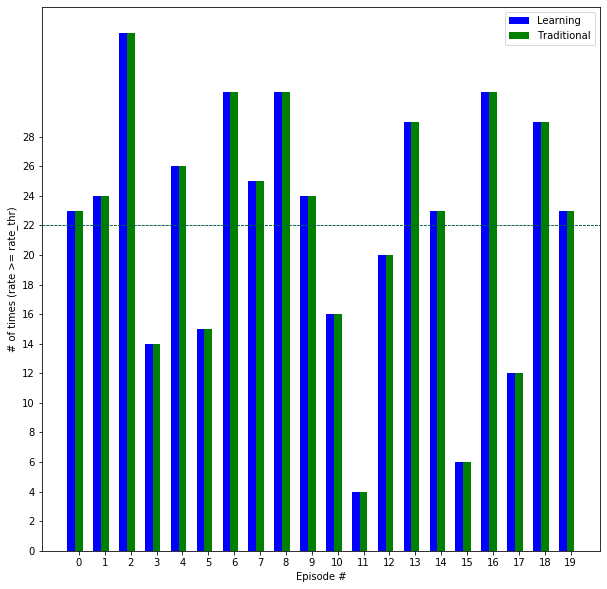

In [56]:
print("Avg Perf Score of an Episode, RL: {}, Traditional method: {}, Perf_Score_Accuracy: {}".format(np.mean(learn_perf_scores), np.mean(trad_perf_scores), np.mean(learn_perf_scores)/np.mean(trad_perf_scores) ))



# plot the histogram
w=0.3
fig = plt.figure(figsize=(10,10))
x_axis = np.arange(test_episodes)
ax = fig.add_subplot(111)
rects1 = ax.bar(x_axis-w, learn_perf_scores, w, color='b')
rects2= ax.bar(x_axis, trad_perf_scores, w, color='g')
#plt.legend(loc='upper right')
ax.legend( (rects1[0], rects2[0]), ('Learning', 'Traditional'), loc='upper right' )
plt.ylabel('# of times (rate >= rate_thr)')
plt.xlabel('Episode #')
ax.set_xticks(x_axis)
ax.set_yticks(np.arange(0.0,30,2))

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        #ax.text(rect.get_x()+rect.get_width()/2., 1.03*h, '%.2f'%np.around(h, decimals=2),
        #        ha='center', va='bottom')

ax.axhline(np.mean(learn_perf_scores), color='b', linewidth=0.75, linestyle='--')
ax.axhline(np.mean(trad_perf_scores), color='g', linewidth=0.75, linestyle='--')
autolabel(rects1)
autolabel(rects2)
plt.show()

In [57]:
print(em.env.rate_threshold)

0.28
